# EP1 - Conjunto de Maldelbrot e paralelização com pThreads e OpenMP

| Nome | NUSP |
|------|------|
| Giulia C. de Nardi | 10692203 |
| Vitor D. Tamae | 10705620 |
| Lucy Anne de Omena Evangelista | 11221776 |
| Leonardo Costa Santos | 10783142 |
| Alexandre Muller Jones | 8038149 |


Caso não queira rodar novamente os experimentos, por favor pular para a sessão "Gráficos comparativos".

## Configuração do ambiente

Atualizando os pacotes Julia

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %Fetching: [======>                                  ]  14.5 %                         ]  35.9 %=======================>                 ]  57.5 %Fetching: [===============================>         ]  77.0 %>]  98.4 % Resolving package versions...
 Installed StatsFuns ─ v0.9.5
 Installed Plots ───── v1.3.2
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [91a5bcdd] ↑ Plots v1.3.0 ⇒ v1.3.2
  [4c63d2b9] ↑ StatsFuns v0.9.4 ⇒ v0.9.5
  Building Plots → `~/.julia/packages/Plots/FYxdA/deps/build.log`


Verificando o status dos pacotes, e se há algum problema, com o comando:

In [2]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.0
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.2
  [b964fa9f] LaTeXStrings v1.1.0
  [8314cec4] PGFPlotsX v1.2.6
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6
  [10745b16] Statistics 


Chamando pacotes que usaremos:

In [ ]:
using DataFrames, Query, StatsPlots, Statistics

## Funções para realização dos experimentos

In [11]:
; make mandelbrot_seq

make: 'mandelbrot_seq' is up to date.


In [12]:
; ./mandelbrot_seq

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq -0.188 -0.012 0.554 0.754 11500


In [13]:
; ./mandelbrot_seq 0.175 0.375 -0.1 0.1 200 0

0.039157


A função abaixo recebe parâmetros `size`, com o tamanho da imagem, `f`, com a id do tupo de fractal a ser feito (0 - Full, 2 - Triple Spiral, 3 - Elephant, 4 - Seahorse), `mandel`, com o nome da função a ser executada (`./mandelbrot_seq`, `./mandelbrot_opm`, `./mandelbrot_pth`),e `threads`, com o número de threads do programa paralelo. A função executa o programa `mandelbrot` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [62]:
function measure_mandelbrot(size, f, mandel; thread = 0)    
    if f == 0  mode = `-2.5 1.5 -2.0 2.0` #full
    elseif f == 1  mode = `-0.188 -0.012 0.554 0.754` #triple spiral
    elseif f == 2  mode = `0.175 0.375 -0.1 0.1` # elephant
    elseif f == 3  mode = `-0.8 -0.7 0.05 0.15` #seahorse
    end
    
    if thread != 0 
    results = parse.(Float64,
        split(chomp(read(`./$mandel $mode $size $thread`, String)), ","))
    else
    results = parse.(Float64,
        read(`./$mandel $mode $size`, String))
    end
    
    if thread == 0
    return DataFrame(size = size,
        f = f,
        threads = thread,
        duration = results[1])
    end
    
    return DataFrame(size = size,
        f = f,
        threads = thread,
        duration = results[1],
        io_duration = results[2])
end

measure_mandelbrot (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `f`,`mandel` e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [63]:
function run_experiments(size, f, mandel, repetitions; threads = [])
    run(`make $mandel`)
    
    
    
    
    if threads != []
        
    results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        duration = Float64[],
        io_alocation = Float64[]) 
        
    for t in threads
        for s in size
        for r in 1:repetitions
            append!(results,
                measure_mandelbrot(s, f, mandel, thread = t))    
        end
        end
    end
    else
        results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        duration = Float64[]) 
        
        for r in 1:repetitions
        for s in size
            append!(results,
                measure_mandelbrot(s, f, mandel))    
        end
        end
    end 
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads.

In [67]:
function parse_results(results)
    if results.threads[1] == 0
        parsed_results = results |>
                    @groupby({_.threads,_.size}) |>
                    @map({threads = key(_).threads,
                          size = _.size[1],
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    else
    parsed_results = results |>
                    @groupby({_.threads,_.size}) |>
                    @map({threads = key(_).threads,
                          size = _.size[1],
                          mean_duration = mean(_.duration),
                          mean_io_alocation = mean(_.io_alocation),
                          ci_duration = 1.96 * std(_.duration),
                          ci_io_alocation = 1.96 * std(_.io_alocation)}) |>
                    DataFrame
    end
    return parsed_results
end

parse_results (generic function with 1 method)

## Funções para traçar gráficos

A função abaixo permite que sejam traçadas até 5 séries de dados em um mesmo gráfico do tipo scatter.

In [5]:
pgfplotsx()

function plot_results(x, y, series_label, yerror; y2 = [], series_label2 = [], yerror2 = [], 
        y3 = [], series_label3 = [], yerror3 = [], y4 = [], series_label4 = [], yerror4 = [],
        y5 = [], series_label5 = [], yerror5 = [])
    max_thread_power = 5
    
    p = scatter(x, y, xaxis = :log2, xlabel = "Threads", xticks = [2 ^ x for x in 0:max_thread_power],
        yerror = yerror, alpha = 0.6, 
        labels = series_label, legend = :bottomright)
    
    if y2 != []
        p = scatter!(x, y2, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror2, alpha = 0.6,
            labels = series_label2, legend = :bottomright)
    end
    if y3 != []
        p = scatter!(x, y3, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror3, alpha = 0.6,
            labels = series_label3, legend = :bottomright)
    end
    if y4 != []
        p = scatter!(x, y4, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror4, alpha = 0.6,
            labels = series_label4, legend = :bottomright)
    end
    if y5 != []
        p = scatter!(x, y5, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror5, alpha = 0.6,
            labels = series_label5, legend = :bottomright)
    end
    
    return p
end

plot_results (generic function with 1 method)

## Condições para os experimentos

In [57]:
#size = [2 ^ x for x in 4:13]
#thread = [2 ^ x for x in 0:5]
#repetitions = 10;
size = [2 ^ x for x in 4:7]
thread = [2 ^ x for x in 0:3]
repetitions = 1;

# Gerando e Salvando dados

## Mandelbrot sequencial

Nesta parte, traremos a execução do maldelbrot em sua versão sequencial, junto com a análise de tempo de execução para os diferentes tipo de fractais (Triple Spiral, Elephant, Seahorse & Full) e em diferentes resoluções ($ 2^4 \cdots 2^{13}$)

Realizando as medições para o mandelbrot sequencial:

In [68]:
results_seq_full = run_experiments(size, 0, "mandelbrot_seq", repetitions)
seq_full = parse_results(results_seq_full);

make: 'mandelbrot_seq' is up to date.


In [33]:
results_seq_triplespiral = run_experiments(size, 1, "mandelbrot_seq", repetitions)
seq_triplespiral = parse_results(results_seq_triplespiral);

make: 'mandelbrot_seq' is up to date.


In [34]:
results_seq_elephant = run_experiments(size, 2, "mandelbrot_seq", repetitions)
seq_elephant = parse_results(results_seq_elephant);

make: 'mandelbrot_seq' is up to date.


In [35]:
results_seq_seahorse = run_experiments(size, 3, "mandelbrot_seq", repetitions)
seq_seahorse = parse_results(results_seq_seahorse);

make: 'mandelbrot_seq' is up to date.


In [50]:
showall(seq_seahorse)

10×4 DataFrame
│ Row │ threads │ size  │ mean_duration │ ci_duration │
│     │ Int64   │ Int64 │ Float64       │ Float64     │
├─────┼─────────┼───────┼───────────────┼─────────────┤
│ 1   │ 0       │ 16    │ 0.0003967     │ 0.000197817 │
│ 2   │ 0       │ 32    │ 0.0014979     │ 0.00091014  │
│ 3   │ 0       │ 64    │ 0.0059669     │ 0.00361696  │
│ 4   │ 0       │ 128   │ 0.022989      │ 0.0154198   │
│ 5   │ 0       │ 256   │ 0.0830625     │ 0.0610161   │
│ 6   │ 0       │ 512   │ 0.284023      │ 0.183647    │
│ 7   │ 0       │ 1024  │ 1.04632       │ 0.299888    │
│ 8   │ 0       │ 2048  │ 5.07424       │ 0.966617    │
│ 9   │ 0       │ 4096  │ 19.8162       │ 4.17241     │
│ 10  │ 0       │ 8192  │ 78.8697       │ 13.7573     │

## Mandelbrot com pthreads

In [61]:
results_pth_full = run_experiments(size, 0, "mandelbrot_pth", repetitions,threads=thread)
pth_full = parse_results(results_pth_full);

make: 'mandelbrot_pth' is up to date.


BoundsError: BoundsError: attempt to access 1-element Array{Float64,1} at index [2]

In [51]:
results_pth_triplespiral = run_experiments(size, 1, "mandelbrot_pth", repetitions,threads=thread)
pth_triplespiral = parse_results(results_pth_triplespiral);

gcc -pthread -o mandelbrot_pth mandelbrot_pth.c


InterruptException: InterruptException:

In [52]:
results_pth_elephant = run_experiments(size, 2, "mandelbrot_pth", repetitions,threads=thread)
pth_elephant = parse_results(results_pth_elephant);

make: 'mandelbrot_pth' is up to date.


InterruptException: InterruptException:

In [53]:
results_pth_seahorse = run_experiments(size, 3, "mandelbrot_pth", repetitions,threads=thread)
pth_seahorse = parse_results(results_pth_seahorse);

make: 'mandelbrot_pth' is up to date.


InterruptException: InterruptException:

## Mandelbrot com OpenMP

In [30]:
results_omp_full = run_experiments(size, 0, "mandelbrot_omp", repetitions,threads=thread)
omp_full = parse_results(results_omp_full);

make: 'mandelbrot_omp' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,8.34e-5,1.51032e-5
2,1,32,0.0002593,5.25034e-5
3,1,64,0.0007741,8.20991e-5
4,1,128,0.0027196,0.000378152
5,1,256,0.0098522,0.00121178
6,1,512,0.0364775,0.00131803
7,1,1024,0.208259,0.161465
8,1,2048,0.839414,0.696352
9,1,4096,3.54475,1.25549


In [46]:
results_omp_triplespiral = run_experiments(size, 1, "mandelbrot_omp", repetitions,threads=thread)
omp_triplespiral = parse_results(results_omp_triplespiral);

make: 'mandelbrot_omp' is up to date.


In [47]:
results_omp_elephant = run_experiments(size, 2, "mandelbrot_omp", repetitions,threads=thread)
omp_elephant = parse_results(results_omp_elephant);

make: 'mandelbrot_omp' is up to date.


In [48]:
results_omp_seahorse = run_experiments(size, 3, "mandelbrot_omp", repetitions,threads=thread)
omp_seahorse = parse_results(results_omp_seahorse);

make: 'mandelbrot_omp' is up to date.


In [49]:
showall(omp_seahorse)

60×4 DataFrame
│ Row │ threads │ size  │ mean_duration │ ci_duration │
│     │ Int64   │ Int64 │ Float64       │ Float64     │
├─────┼─────────┼───────┼───────────────┼─────────────┤
│ 1   │ 1       │ 16    │ 0.0005749     │ 6.05274e-5  │
│ 2   │ 1       │ 32    │ 0.0021911     │ 7.65903e-5  │
│ 3   │ 1       │ 64    │ 0.0087471     │ 0.000259819 │
│ 4   │ 1       │ 128   │ 0.0347141     │ 0.000435634 │
│ 5   │ 1       │ 256   │ 0.139952      │ 0.00311937  │
│ 6   │ 1       │ 512   │ 0.558083      │ 0.0121486   │
│ 7   │ 1       │ 1024  │ 1.65257       │ 0.971551    │
│ 8   │ 1       │ 2048  │ 7.14823       │ 2.36527     │
│ 9   │ 1       │ 4096  │ 28.0738       │ 8.6815      │
│ 10  │ 1       │ 8192  │ 144.212       │ 16.0117     │
│ 11  │ 2       │ 16    │ 0.0004016     │ 1.21948e-5  │
│ 12  │ 2       │ 32    │ 0.0013323     │ 0.000136342 │
│ 13  │ 2       │ 64    │ 0.0049774     │ 4.93013e-5  │
│ 14  │ 2       │ 128   │ 0.0196335     │ 0.000193219 │
│ 15  │ 2       │ 256   │ 0.06374

## Salvando dados

In [8]:
using CSV

function save_csv_results(results,filename)
    println(filename)
    CSV.write(filename, results)
end
using CSV

function read_csv_results(filename)
    results=CSV.read(filename)
    return results
end


read_csv_results (generic function with 1 method)

In [37]:
save_csv_results(results_seq_full,"results_data/seq_full.csv")
save_csv_results(results_seq_triplespiral,"data/results_seq_triplespiral.csv")
save_csv_results(results_seq_elephant,"data/results_seq_elephant.csv")
save_csv_results(results_seq_seahorse,"data/results_seq_seahorse.csv");
save_csv_results(seq_full,"data/seq_full.csv")
save_csv_results(seq_triplespiral,"data/seq_triplespiral.csv")
save_csv_results(seq_elephant,"data/seq_elephant.csv")
save_csv_results(seq_seahorse,"data/seq_seahorse.csv");

UndefVarError: UndefVarError: seq_full not defined

In [38]:
save_csv_results(results_omp_full,"data/results_omp_full.csv")
save_csv_results(results_omp_triplespiral,"data/results_omp_triplespiral.csv")
save_csv_results(results_omp_elephant,"data/results_omp_elephant.csv")
save_csv_results(results_omp_seahorse,"data/results_omp_seahorse.csv");
save_csv_results(omp_full,"data/omp_full.csv")
save_csv_results(omp_triplespiral,"data/omp_triplespiral.csv")
save_csv_results(omp_elephant,"data/omp_elephant.csv")
save_csv_results(omp_seahorse,"data/omp_seahorse.csv");

UndefVarError: UndefVarError: omp_full not defined

In [39]:
save_csv_results(results_pth_full,"data/results_pth_full.csv")
save_csv_results(results_pth_triplespiral,"data/results_pth_triplespiral.csv")
save_csv_results(results_pth_elephant,"data/results_pth_elephant.csv")
save_csv_results(results_pth_seahorse,"data/results_pth_seahorse.csv")
save_csv_results(pth_full,"data/pth_full.csv")
save_csv_results(pth_triplespiral,"data/pth_triplespiral.csv")
save_csv_results(pth_elephant,"data/pth_elephant.csv")
save_csv_results(pth_seahorse,"data/pth_seahorse.csv");

UndefVarError: UndefVarError: pth_full not defined

# Gráficos comparativos

Ao final, teremos os dataframes:

|Dataframe | Full | Triple Spiral | Seahorse |
|----------|--------|--------|--------|
|Sequencial|seq_full|seq_triplespiral|seq_seahorse|
|PThreads|pth_full|pth_triplespiral|pth_seahorse|
|OpenMP|omp_full|omp_triplespiral|omp_seahorse|

Carregando os dataframes gerados, para testes futuros:

In [52]:
seq_full=read_csv_results("data/seq_full.csv")
seq_triplespiral=read_csv_results("data/seq_triplespiral.csv")
seq_elephant=read_csv_results("data/seq_elephant.csv")
seq_seahorse=read_csv_results("data/seq_seahorse.csv")
omp_full=read_csv_results("data/omp_full.csv")
omp_triplespiral=read_csv_results("data/omp_triplespiral.csv")
omp_elephant=read_csv_results("data/omp_elephant.csv")
omp_seahorse=read_csv_results("data/omp_seahorse.csv")
pth_full=read_csv_results("data/pth_full.csv")
pth_triplespiral=read_csv_results("data/pth_triplespiral.csv")
pth_elephant=read_csv_results("data/pth_elephant.csv")
pth_seahorse=read_csv_results("data/pth_seahorse.csv");

In [ ]:
results_seq_full=read_csv_results("data/results_seq_full.csv")
results_seq_triplespiral=read_csv_results("data/results_seq_triplespiral.csv")
results_seq_elephant=read_csv_results("data/results_seq_elephant.csv")
results_seq_seahorse=read_csv_results("data/results_seq_seahorse.csv")
results_omp_full=read_csv_results("data/results_omp_full.csv")
results_omp_triplespiral=read_csv_results("data/results_omp_triplespiral.csv")
results_omp_elephant=read_csv_results("data/results_omp_elephant.csv")
results_omp_seahorse=read_csv_results("data/results_omp_seahorse.csv")
results_pth_full=read_csv_results("data/results_pth_full.csv")
results_pth_triplespiral=read_csv_results("data/results_pth_triplespiral.csv")
results_pth_elephant=read_csv_results("data/results_pth_elephant.csv")
results_pth_seahorse=read_csv_results("data/results_pth_seahorse.csv");

Realizaremos os gráficos a partir de partições do dataframe, como mostrados abaixo:

In [15]:
filter(row -> row[:threads] == 1, omp_full)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,8.34e-5,1.51032e-5
2,1,32,0.0002593,5.25034e-5
3,1,64,0.0007741,8.20991e-5
4,1,128,0.0027196,0.000378152
5,1,256,0.0098522,0.00121178
6,1,512,0.0364775,0.00131803
7,1,1024,0.208259,0.161465
8,1,2048,0.839414,0.696352
9,1,4096,3.54475,1.25549


In [16]:
filter(row -> row[:size] == 16, omp_full)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,8.34e-5,1.51032e-5
2,2,16,0.0001573,2.04536e-5
3,4,16,0.0001212,3.2004e-5
4,8,16,0.00596,0.00263079
5,16,16,0.0006273,0.000296602
6,32,16,0.0005376,0.000157688


In [17]:
filter(row -> row[:size] == 16, omp_full).mean_duration

6-element Array{Float64,1}:
 8.34e-5               
 0.00015730000000000003
 0.00012119999999999999
 0.00596               
 0.0006273             
 0.0005376             

Ideias para os gráficos: 
> Comparar desempenho por tamanho da imagem ( 5 grafos > para tamanhos das imagens. Cada serie no grafico deve ser uma forma gerar a imagem)

> Comparar desempenho por tipo de gráfico produzido ( 3 x 4 gráficos, 4 áreas com 3 tipos de calculo cada / cruzar com tamanho da entrada também? daí seriam 4x 3 x 10)

> estou confouzer, me ajudem a saber quais gráficos fazer

### Comparando desempenho por região

#### Sequencial

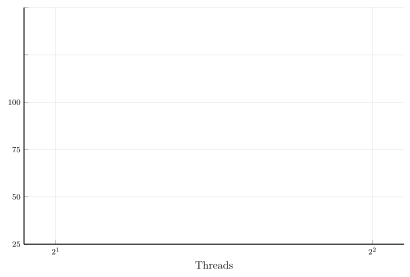

In [53]:
plot_results(seq_full.threads, seq_full.mean_duration, "Full", seq_full.ci_duration,
    y2 = seq_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = seq_seahorse.ci_duration,
    y3 = seq_elephant.mean_duration, series_label3 = "Elephant", yerror3 = seq_elephant.ci_duration,
    y4 = seq_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = seq_triplespiral.ci_duration)

#### OpenMP

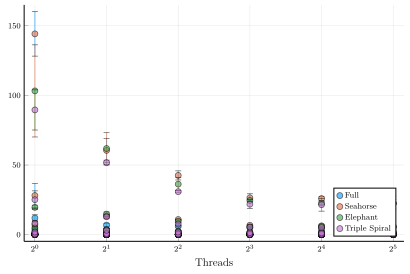

In [48]:
plot_results( omp_full.threads, omp_full.mean_duration, "Full", omp_full.ci_duration,
    y2 = omp_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = omp_seahorse.ci_duration,
    y3 = omp_elephant.mean_duration, series_label3 = "Elephant", yerror3 = omp_elephant.ci_duration,
    y4 = omp_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = omp_triplespiral.ci_duration)

#### PThreads

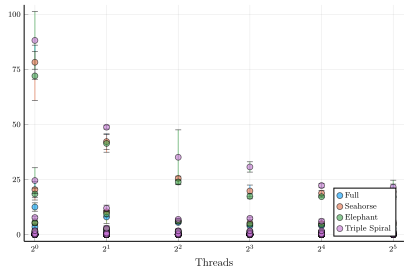

In [51]:
plot_results(pth_full.threads, pth_full.mean_duration, "Full", pth_full.ci_duration,
    y2 = pth_seahorse.mean_duration, series_label2 = "Seahorse", yerror2 = pth_seahorse.ci_duration,
    y3 = pth_elephant.mean_duration, series_label3 = "Elephant", yerror3 = pth_elephant.ci_duration,
    y4 = pth_triplespiral.mean_duration, series_label4 = "Triple Spiral", yerror4 = pth_triplespiral.ci_duration)

In [ ]:
plot_results(
    filter(row -> row[:size] == 16, omp_ful0l).threads,
    filter(row -> row[:size] == 16, omp_full).mean_duration, "Full", 
    filter(row -> row[:size] == 16, omp_full).ci_duration,
    y2 = filter(row -> row[:size] == 32, omp_full).mean_duration,
    series_label2 = "32", yerror2 = filter(row -> row[:size] == 32, omp_full).ci_duration)

### Comparando desempenho por quantidade de threads

In [45]:
function fazgrafico(filename, label)
    
    plot_results(filename.threads, filename.mean_duration, label, filename.ci_duration)
end   

fazgrafico (generic function with 1 method)

In [44]:
fazgrafico(pth_full, "pth_full")

ArgumentError: ArgumentError: column name :mean_duration not found in the data frame

In [40]:
fazgrafico(seq_full, "seq_full") #, filename2 = seq_seahorse, label2 = "seq_seahorse")

ErrorException: type Array has no field mean_duration

In [38]:
seq_seahorse

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,0.0003967,0.000197817
2,0,32,0.0014979,0.00091014
3,0,64,0.0059669,0.00361696
4,0,128,0.022989,0.0154198
5,0,256,0.0830625,0.0610161
6,0,512,0.284023,0.183647
7,0,1024,1.04632,0.299888
8,0,2048,5.07424,0.966617
9,0,4096,19.8162,4.17241


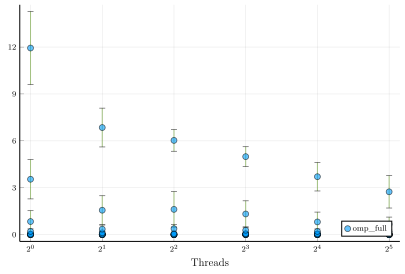

In [23]:
fazgrafico(omp_full, "omp_full")


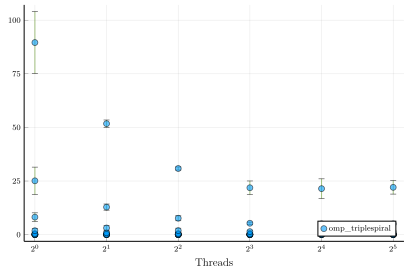

In [24]:
fazgrafico(omp_triplespiral, "omp_triplespiral")


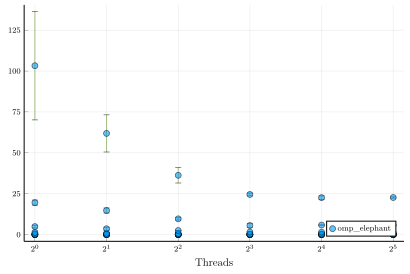

In [25]:
fazgrafico(omp_elephant, "omp_elephant")


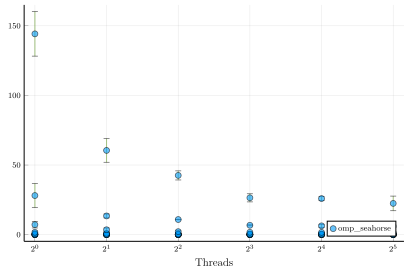

In [26]:
fazgrafico(omp_seahorse, "omp_seahorse")